<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/verao_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import io
import gzip
import pandas as pd
import seaborn as sns; sns.set_theme(style="whitegrid")

In [2]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, parse_dates=["date"], dtype={"city_ibge_code": str})

In [19]:
cols = "MUNICIPIO","COD_IBGE","CLUSTER","UF"
cidades_turisticas = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/RELATORIO_CATEGORIZACAO_2019-Portal.xls?raw=true', usecols=cols, dtype={"COD_IBGE": str})
cidades = cidades_turisticas.MUNICIPIO.to_list()

In [20]:
cidades_turisticas[cidades_turisticas.isna().any(axis=1)]

,UF,MUNICIPIO,COD_IBGE,CLUSTER


In [21]:
covid_cidades_turisticas = covid.loc[covid['city'].isin(cidades)]
covid_cidades_turisticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002441 entries, 0 to 1977902
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype         
---  ------                                         --------------    -----         
 0   city                                           1002441 non-null  object        
 1   city_ibge_code                                 1002441 non-null  object        
 2   date                                           1002441 non-null  datetime64[ns]
 3   epidemiological_week                           1002441 non-null  int64         
 4   estimated_population                           1002441 non-null  float64       
 5   estimated_population_2019                      1002441 non-null  float64       
 6   is_last                                        1002441 non-null  bool          
 7   is_repeated                                    1002441 non-null  bool          
 8   last_available_confirmed        

In [22]:
covid_cidades_turisticas.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [23]:
covid_tur = pd.merge(covid_cidades_turisticas, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left").dropna(subset=['CLUSTER'])

In [24]:
def aumento_percentual(t0, t1):
  return (t1-t0)/t0 if t0 != 0 else 0

def calcula_aumento_relativo(df, x_col, date_col, from_date, to_date):
    from_x = int(df[df[date_col] == from_date][x_col])
    to_x = int(df[df[date_col] == to_date][x_col])
    abs_dif = to_x - from_x
    relative_dif = aumento_percentual(from_x, to_x)
    return {f'{x_col}_from': from_x, f'{x_col}_to': to_x, 'dif': abs_dif,'relative_dif': relative_dif}

In [25]:
covid_tur_aumento = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2020-12-17', to_date='2021-03-16').to_frame()
covid_tur_aumento.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento = covid_tur_aumento['explodir'].apply(pd.Series)
covid_tur_aumento.reset_index(inplace=True)
covid_tur_aumento.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
1783,4106506,20580.0,2.0,39.0,37.0,18.500000
2009,4206652,4698.0,1.0,13.0,12.0,12.000000
1235,3170503,10345.0,1.0,13.0,12.0,12.000000
733,2923605,21695.0,1.0,12.0,11.0,11.000000
1075,3145109,16832.0,1.0,12.0,11.0,11.000000
...,...,...,...,...,...,...
2273,4311270,1607.0,0.0,4.0,4.0,0.000000
576,2706448,13332.0,11.0,11.0,0.0,0.000000
735,2923902,9686.0,19.0,18.0,-1.0,-0.052632
193,2102705,22117.0,4.0,3.0,-1.0,-0.250000


In [26]:
covid_tur_aumento_categorias = pd.merge(covid_tur_aumento, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias = covid_tur_aumento_categorias[covid_tur_aumento_categorias.estimated_population >= 10000]
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,CLUSTER
0,1100023,109523.0,120.0,255.0,135.0,1.125000,RO,Ariquemes,1100023,C
2,1100049,85893.0,51.0,125.0,74.0,1.450980,RO,Cacoal,1100049,B
3,1100056,16204.0,6.0,17.0,11.0,1.833333,RO,Cerejeiras,1100056,D
4,1100064,15544.0,4.0,11.0,7.0,1.750000,RO,Colorado do Oeste,1100064,D
5,1100080,18798.0,7.0,13.0,6.0,0.857143,RO,Costa Marques,1100080,D
...,...,...,...,...,...,...,...,...,...,...
2660,5221403,129823.0,172.0,230.0,58.0,0.337209,GO,Trindade,5221403,B
2662,5221601,40840.0,30.0,47.0,17.0,0.566667,GO,Uruaçu,5221601,B
2664,5221858,172135.0,135.0,187.0,52.0,0.385185,GO,Valparaíso de Goiás,5221858,D
2665,5222005,13977.0,4.0,8.0,4.0,1.000000,GO,Vianópolis,5222005,D


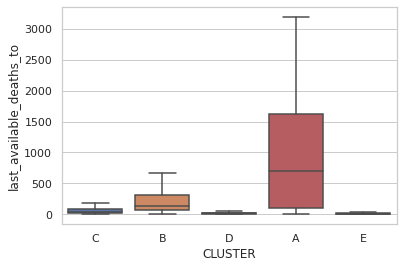

In [27]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias, showfliers = False)

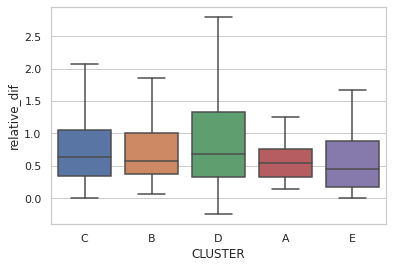

In [28]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias, showfliers = False)

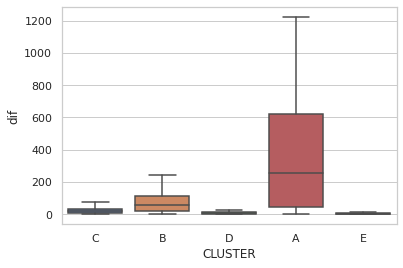

In [29]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias, showfliers = False)

In [30]:
categorias = pd.concat([covid_tur_aumento_categorias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [31]:
categorias.reset_index(inplace=True)
categorias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,61,953133.065574,413418.0,1245.852459,450.0,1804.639344,694.0,558.786885,255.0,0.590747,0.536103,0.469414
1,B,247,177728.704453,118516.0,154.076923,82.0,241.591093,134.0,87.514170,57.0,0.797198,0.573864,0.693577
2,C,440,68916.186364,46332.5,53.400000,28.5,83.950000,47.0,30.550000,18.0,0.854088,0.635939,0.718114
3,D,965,26081.930570,19148.0,15.727461,9.0,25.530570,17.0,9.803109,7.0,1.042530,0.680851,0.903582
4,E,69,18080.014493,14446.0,9.753623,7.0,15.463768,12.0,5.710145,3.0,0.791551,0.450000,0.763206


**Métricas em ordem decrescente**

In [32]:
mediana_aumento_mortalidade_abs = categorias.sort_values(ascending=False, by="dif_median")
mediana_aumento_mortalidade_abs[["CLUSTER","dif_median"]]

,CLUSTER,dif_median
0,A,255.0
1,B,57.0
2,C,18.0
3,D,7.0
4,E,3.0


In [33]:
mediana_aumento_mortalidade_rel = categorias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
3,D,0.680851
2,C,0.635939
1,B,0.573864
0,A,0.536103
4,E,0.450000


In [34]:
aumento_considerando_populacao = categorias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
3,D,0.903582
4,E,0.763206
2,C,0.718114
1,B,0.693577
0,A,0.469414


In [40]:
covid_tur_aumento_categorias

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,CLUSTER
0,1100023,109523.0,120.0,255.0,135.0,1.125000,RO,Ariquemes,1100023,C
2,1100049,85893.0,51.0,125.0,74.0,1.450980,RO,Cacoal,1100049,B
3,1100056,16204.0,6.0,17.0,11.0,1.833333,RO,Cerejeiras,1100056,D
4,1100064,15544.0,4.0,11.0,7.0,1.750000,RO,Colorado do Oeste,1100064,D
5,1100080,18798.0,7.0,13.0,6.0,0.857143,RO,Costa Marques,1100080,D
...,...,...,...,...,...,...,...,...,...,...
2660,5221403,129823.0,172.0,230.0,58.0,0.337209,GO,Trindade,5221403,B
2662,5221601,40840.0,30.0,47.0,17.0,0.566667,GO,Uruaçu,5221601,B
2664,5221858,172135.0,135.0,187.0,52.0,0.385185,GO,Valparaíso de Goiás,5221858,D
2665,5222005,13977.0,4.0,8.0,4.0,1.000000,GO,Vianópolis,5222005,D


In [44]:
covid_tur_aumento_categorias.groupby('CLUSTER')['UF'].value_counts().to_frame().unstack()

UF                               ...                                   
UF        AC    AL    AM   AP    BA    CE  ...   RR    RS    SC    SE     SP   TO
CLUSTER                                    ...                                   
A        1.0   2.0   1.0  1.0   5.0   2.0  ...  1.0   2.0   5.0   1.0   11.0  1.0
B        NaN   1.0   NaN  NaN  21.0  12.0  ...  NaN  21.0  17.0   NaN   49.0  2.0
C        2.0   6.0   9.0  2.0  27.0  24.0  ...  NaN  36.0  21.0   6.0   82.0  6.0
D        6.0  24.0  13.0  3.0  58.0  25.0  ...  6.0  82.0  49.0  22.0  130.0  7.0
E        2.0   5.0   1.0  1.0   8.0   4.0  ...  NaN   2.0   1.0   5.0    3.0  1.0

[5 rows x 27 columns]